# ECE 4710 Final Data Challenge

A taxi company is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an rider share app account. We consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days. **The data was collected at the end of June 30, 2014.**
We would like you to use this dataset to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help the company.
The data is in the attached file data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis.
2. Build a predictive model to help the company determine whether or not a user will be active
on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.

In [1]:
#set up environment
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#load data and visualize
with open('train.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,Winterfell,1,2014-01-27,3.5,1.67,2014-06-22,iPhone,33.3,True,16.7,2.10,4.8
1,King's Landing,1,2014-01-11,5.0,1.00,2014-06-08,iPhone,0.0,False,0.0,7.30,5.0
2,King's Landing,0,2014-01-23,3.0,1.00,2014-06-27,iPhone,0.0,True,100.0,4.00,5.0
3,King's Landing,0,2014-01-17,4.0,1.00,2014-05-31,Android,0.0,False,33.3,6.73,5.0
4,King's Landing,1,2014-01-28,5.0,1.16,2014-06-20,iPhone,26.9,True,50.0,2.48,4.8


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47500 entries, 0 to 47499
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    47500 non-null  object 
 1   trips_in_first_30_days  47500 non-null  int64  
 2   signup_date             47500 non-null  object 
 3   avg_rating_of_driver    39746 non-null  float64
 4   avg_surge               47500 non-null  float64
 5   last_trip_date          47500 non-null  object 
 6   phone                   47128 non-null  object 
 7   surge_pct               47500 non-null  float64
 8   ultimate_black_user     47500 non-null  bool   
 9   weekday_pct             47500 non-null  float64
 10  avg_dist                47500 non-null  float64
 11  avg_rating_by_driver    47311 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.4+ MB


In [3]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,47500.000000,39746.000000,47500.000000,47500.000000,47500.000000,47500.000000,47311.000000
mean,2.275158,4.602186,1.074716,8.852829,60.966623,5.799024,4.778400
std,3.789220,0.617603,0.222291,19.993570,37.064133,5.677958,0.447863
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.890000,5.000000
75%,3.000000,5.000000,1.050000,8.500000,100.000000,6.950000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,129.890000,5.000000


### 1. EDA
a. First of all, all the users will need to be labled by active or inactive, and categorical variables must be encoded. The null values must be accounted for. While the reason for the missing ratings cannot be inferred, it seems reasonable that the user/driver simply declined to input a rating. In this case, we will fill with the **mean value** so as to not affect the current distribution, which is primarily high ratings.

In [4]:
#fill missing values in avg_rating_by_driver and avg_rating_of_driver
avg_rating_by_driver_mean = df['avg_rating_by_driver'].mean()
avg_rating_of_driver_mean = df['avg_rating_of_driver'].mean()

df['avg_rating_by_driver'].fillna(avg_rating_by_driver_mean, inplace=True)
df['avg_rating_of_driver'].fillna(avg_rating_of_driver_mean, inplace=True)

b. The target variable will be whether the user was active. Convert the signup date and last trip date to datetime objects. If the last trip is in June, then encode each user active as True, else False.

In [5]:
#set as datatime objects
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [6]:
#encode target variable 'active' as true or false for last trip in june
# you can add more lines before assigning the 'active' column
df['active'] = (df['last_trip_date'].dt.month == 6)
df['active'].sum()

17320

#### What is the ratio of Active Users to Inactive Users?
Compute the percentage of active users among all users, and make a plot to visualize it.

Percentage of active users: 36.46%


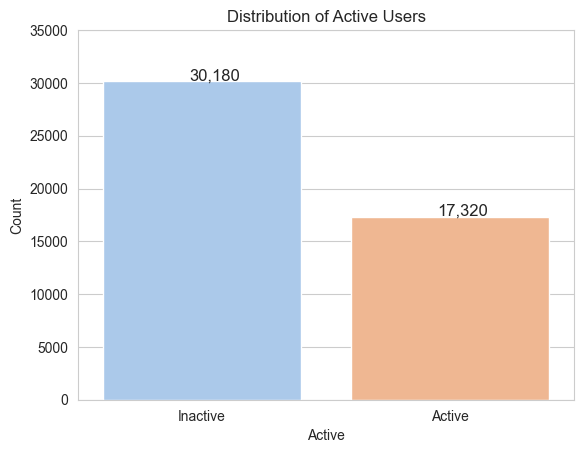

In [7]:
#Calculate ratio of active to all users
#Visualization
# Compute percentage of active users
active_users = df['active'].sum()
total_users = len(df)
percent_active = round(active_users / total_users * 100, 2)
print(f'Percentage of active users: {percent_active}%')
# Visualize percentage of active users
sns.set_style('whitegrid')
sns.countplot(x='active', data=df, palette='pastel')
plt.title('Distribution of Active Users')
plt.xlabel('Active')
plt.ylabel('Count')
plt.xticks([0, 1], ['Inactive', 'Active'])
plt.ylim(0, 35000)
for index, value in df['active'].value_counts().items():
    plt.text(index-0.05, value+100, s=f'{value:,}', fontdict=dict(fontsize=12))
plt.show()

Unsurprisingly the classes are imbalanced, but not tremendously. This should not present too much of a problem while modeling.
## 2. Modeling

Now, please perform feature engineering to build a model that can predict whether the users are active. (To get full credit, you need to make some visualization and try out several different models using cross validation)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
import pprint

In [9]:
df['phone'] = df['phone'].astype('category')
df = pd.get_dummies(df, columns=['city', 'phone'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47500 entries, 0 to 47499
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  47500 non-null  int64         
 1   signup_date             47500 non-null  datetime64[ns]
 2   avg_rating_of_driver    47500 non-null  float64       
 3   avg_surge               47500 non-null  float64       
 4   last_trip_date          47500 non-null  datetime64[ns]
 5   surge_pct               47500 non-null  float64       
 6   ultimate_black_user     47500 non-null  bool          
 7   weekday_pct             47500 non-null  float64       
 8   avg_dist                47500 non-null  float64       
 9   avg_rating_by_driver    47500 non-null  float64       
 10  active                  47500 non-null  bool          
 11  city_Astapor            47500 non-null  uint8         
 12  city_King's Landing     47500 non-null  uint8      

### Choose features to use

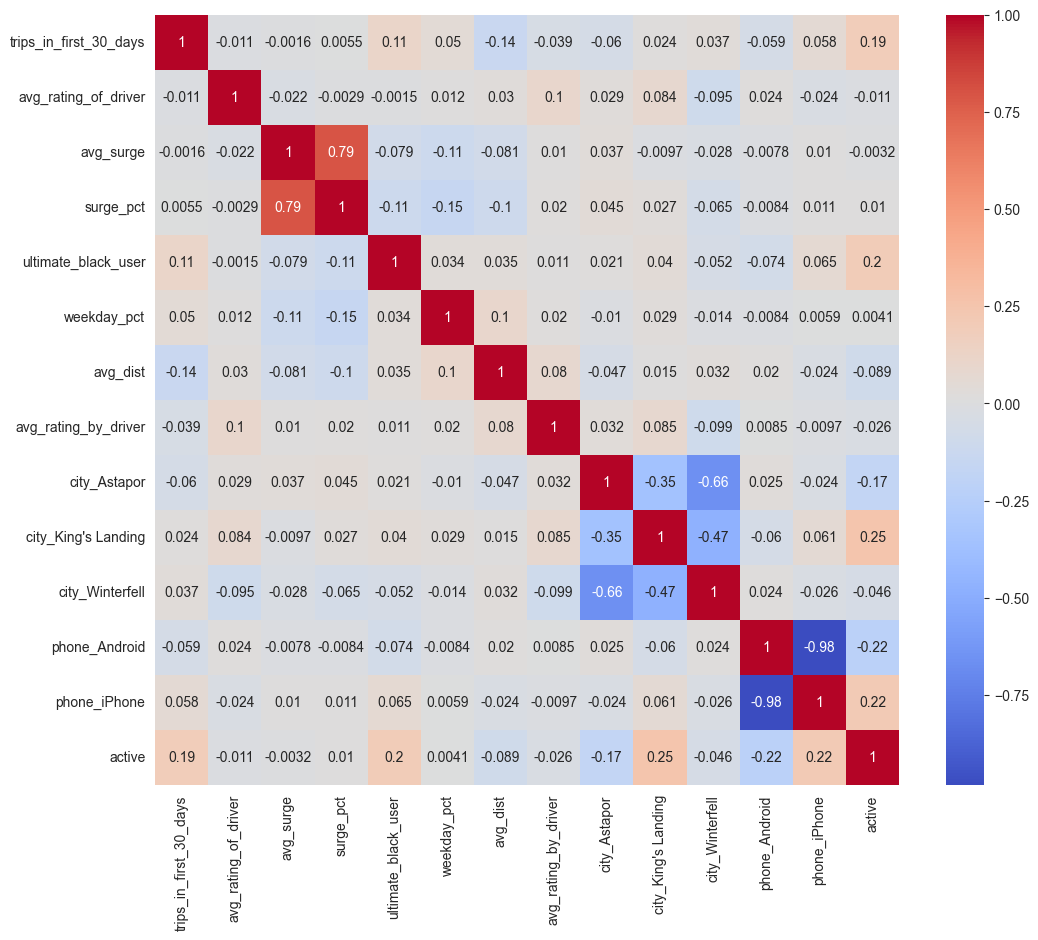

In [10]:
X = df.drop(['active', 'signup_date', 'last_trip_date'], axis=1)
y = df['active']
# Calculate the correlation coefficient matrix
corr = pd.concat([X, y], axis=1).corr()
# Draw a Heat Map of the correlation coefficient matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Heat map indicates that the most crucial features that influence user's activity are `trips_in_last_30_days` ,  `ultimate_black_user` ,  `city_King's Landing` , `phone_iPhone`, `surge_pct` and `weekday_pct`.

In [11]:
features = ['trips_in_first_30_days', 'ultimate_black_user', "city_King's Landing", 'phone_iPhone', 'surge_pct', 'weekday_pct']

### Choose model to use

-------------------------------------
Accuracy for DecisionTreeClassifier:
Train data: 0.851
Test data: 0.7490526315789474


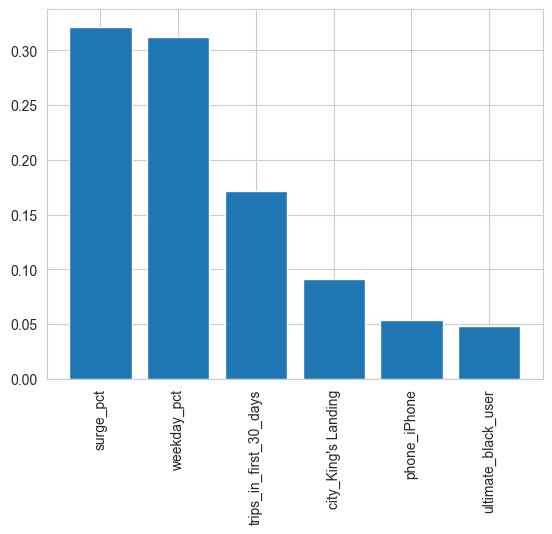

-------------------------------------
Accuracy for RandomForestClassifier:
Train data: 0.851
Test data: 0.7648421052631579


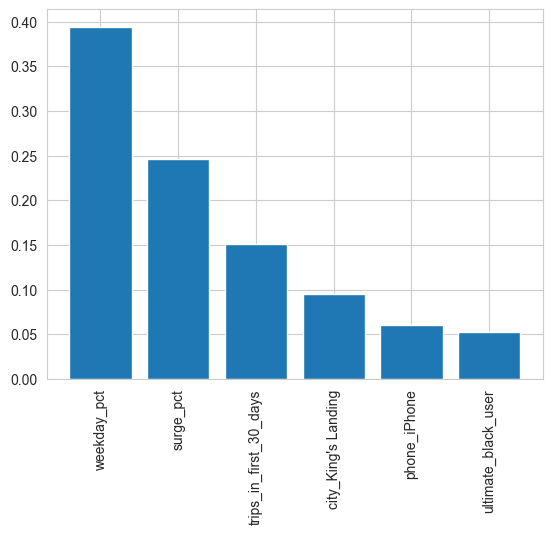

-------------------------------------
Accuracy for GradientBoostingClassifier:
Train data: 0.7720263157894737
Test data: 0.7690526315789473


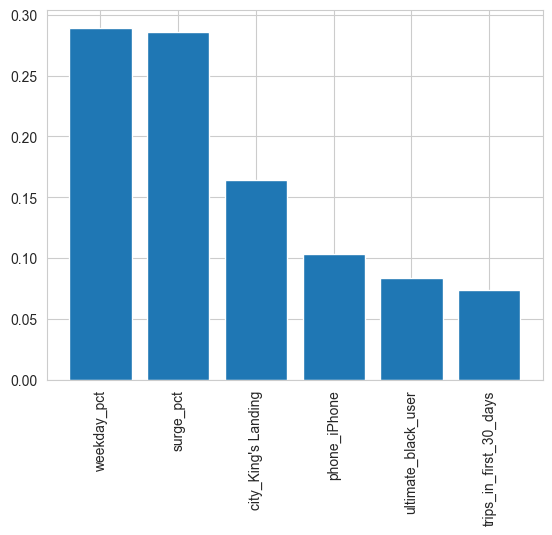

In [12]:
# Splitting the data into training and testing sets
X = df[features]
y = df['active']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Building and evaluating multiple models
models = [DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
for model in models:
    model.fit(X_train_scaled, y_train)
    scores_train = np.sum(model.predict(X_train_scaled) == y_train) / X_train_scaled.shape[0]
    scores_test = np.sum(model.predict(X_test_scaled) == y_test) / X_test_scaled.shape[0]
    print("-------------------------------------")
    print(f'Accuracy for {type(model).__name__}:')
    print(f"Train data: {scores_train.mean()}")
    print(f"Test data: {scores_test.mean()}")

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.show()

**Conclusion:**
- Based on the analysis,  `trips_in_last_30_days` ,  `ultimate_black_user` ,  `city_King's Landing` ,  `phone_iPhone` ,  `surge_pct`  and  `weekday_pct`  are identified as the six key factors that are responsible for prediction.
- Among the three models, GradientBoostingClassifier is the most suitable one to choose as it provides the highest accuracy on the testing dataset.


## 3. Model Evaluation

The bottom line here is: Was the model useful? You need to check different performance metrics and explain your choice. You are also required to make a visual metric (ROC curve/ Precision recall)

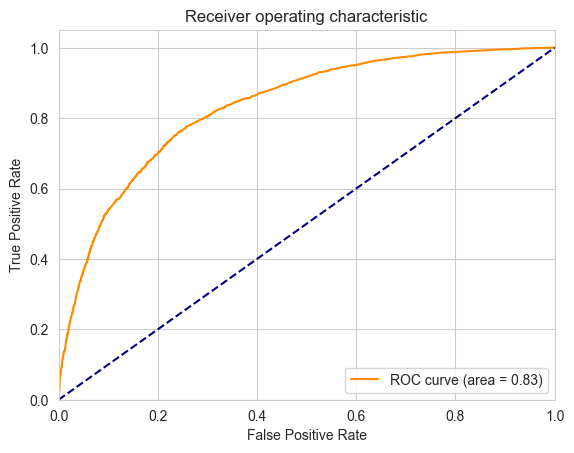

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming that y_true and y_score are the true labels and predicted scores from the model
model = GradientBoostingClassifier()
model.fit(X_train_scaled, y_train)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
# Calculate the AUC score
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## 4. Final Submission




The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to get credit for this question.**

Save your predictions in a 1-dimensional array called `test_predictions` (contains 0 and 1s). 

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. 



### Submission on Gitea

Please push all your work (ipynb, submission.csv) to the `-final` repo on Gitea. All your work should be on the master branch. 

### Submission on Canvas

Export a pdf version of your notebook with all your code and visualizations and submit it on canvas. Do NOT push the pdf to Gitea!



In [14]:
test = pd.read_csv('test.csv')
#fill missing values in avg_rating_by_driver and avg_rating_of_driver
avg_rating_by_driver_mean = test['avg_rating_by_driver'].mean()
avg_rating_of_driver_mean = test['avg_rating_of_driver'].mean()

test['avg_rating_by_driver'].fillna(avg_rating_by_driver_mean, inplace=True)
test['avg_rating_of_driver'].fillna(avg_rating_of_driver_mean, inplace=True)

test['phone'] = test['phone'].astype('category')
test = pd.get_dummies(test, columns=['city', 'phone'])
features = ['trips_in_first_30_days', 'ultimate_black_user', "city_King's Landing", 'phone_iPhone', 'surge_pct', 'weekday_pct']

X = test[features]

scaler = StandardScaler()
X = scaler.fit_transform(X)

test_predictions = model.predict(X)

In [15]:
test_predictions.sum()

859

In [16]:
submission_df = pd.DataFrame({ 
    "active": test_predictions
}, columns=['active'])
submission_df.to_csv("submission.csv", index=False)

print('Created a CSV file: submission.csv')
print('You may now upload this CSV file to Gitea for grading.')

Created a CSV file: submission.csv
You may now upload this CSV file to Gitea for grading.
